In [1]:
# %pip install -U pip datasets ipywidgets
# For mac OS
# %pip install -U tensorflow==2.16.2 tensorflow-macos==2.16.2 keras==3.4.1 keras-nlp
# 20240803, tensorflow-text can be installed on Apple Silicon mac now!
# %pip install tensorflow-text
# For Intel mac
# %pip install -U tensorflow==2.16.2 tensorflow-text keras==3.4.1 keras-nlp
# For AWS SageMaker
# %pip install -U tensorflow==2.16.2 tensorflow-datasets tensorflow-text keras==3.4.1 keras-nlp datasets rouge-score py7zr

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [3]:
# Utility function to determine where this note is running
import platform

def is_running_on_apple_silicon():
    """
    Determine if this is running on Apple Silicon Mac.
    """
    return platform.system() == "Darwin" and platform.processor() == "arm"

def is_running_on_intel_mac():
    """
    Determine if this is running on Intel Mac.
    """
    return platform.system() == "Darwin" and platform.processor() == "i386"

# This flag is used for tf.debugging.experimental.enable_dump_debug_info.
# However, this makes 10 times slower.
DEBUGGER_V2 = False

In [4]:
import tensorflow as tf
import keras
import keras_nlp
print("Tensorflow 2.17.0 is expected. The running version is", tf.__version__)
print("Keras 3.4.1 is expected. The running version is", keras.__version__)
print("KerasNLP 0.12.1 is expected. The running version is", keras_nlp.__version__)

if is_running_on_apple_silicon() or is_running_on_intel_mac():
    FLOAT_TYPE = tf.float32
else:
    """
    # Mixed-precision training
    Deep Learning with Python, Second Edition
    François Chollet

    However, this makes the processing 2.x slower on M2 Apple Silicon.

    Machine | 1 step
    --- | ---
    Intel Mac - fp32 : fp16 | 1 : 1.714
    Apple Silicon M2 (Mac Book Pro) - fp32 : fp16 | 1 : 2.813
    NVIDIA V100 GPU x 1 (ml.p3.2xlarge) - fp32 : fp16 | 1 : 0.875    Intel Mac - fp32 : fp16 | 1 : 1.714
    """
    keras.mixed_precision.set_global_policy("mixed_float16")
    FLOAT_TYPE = tf.float16

import numpy as np
import tensorflow_datasets as tfds
# SageMaker cannot use @keras.saving
from keras import saving
import datetime

Tensorflow 2.17.0 is expected. The running version is 2.17.0
Keras 3.4.1 is expected. The running version is 3.4.1
KerasNLP 0.12.1 is expected. The running version is 0.12.1


# Utility function

In [5]:
import matplotlib.pyplot as plt

def plot(history, title=None, keys=["loss", "masked_acc"]):
    """
    Display the plot that indicates the loss and accuracy.
    :param history: history object from the tensorflow fit function.
    :param title: title text.
    :param keys: keys for plotting.
    """
    for key in keys:
        if 'loss' in key:
            print(
                np.min(history.history[f"val_{key}"]),
                "The best number of epocs for the validation loss is",
                np.argmin(history.history[f"val_{key}"]) + 1,
            )
        else:
            print(
                np.max(history.history[f"val_{key}"]),
                "The best number of epocs for the validation accuracy is",
                np.argmax(history.history[f"val_{key}"]) + 1,
            )

    flg, axes = plt.subplots(1, 2, tight_layout=True)
    if title is not None:
        flg.suptitle(t=title, fontsize=14)
    for i, key in enumerate(keys):
        value = history.history[key]
        val_loss = history.history[f"val_{key}"]
        epochs = range(1, len(value) + 1)
        axes[i].plot(epochs, value, label=f"Training {key}")
        axes[i].plot(epochs, val_loss, label=f"Validation {key}")
        axes[i].set_title(f"Training and validation {key}")
        axes[i].set_xlabel("epochs")
        axes[i].set_ylabel(key)
        axes[i].legend()
    plt.show()


In [6]:
def get_log_dir(now):
    log_dir = "logs/fit/" + now.strftime("%Y%m%d-%H%M%S")
    return log_dir

def get_tensorboard_callback(now):
    """
    Create the TensorBoard callback
    """
    # @see https://www.tensorflow.org/tensorboard/get_started
    log_dir = get_log_dir(now=now)
    tensorboard_callback = keras.callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=1
    )
    return tensorboard_callback

In [7]:
# @see https://github.com/keras-team/keras-nlp/blob/50e041487b1d8b30b34c5fb738db3ed3406363bc/examples/machine_translation/data.py
import string
import re

strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

@saving.register_keras_serializable()
def custom_standardization(input_string):
    """
    Define the custom standardization to remove useless characters.
    """
    input_string = tf.strings.regex_replace(input_string, r'\r\n', ' ')
    input_string = tf.strings.regex_replace(input_string, r'\\r\\n', ' ')
    input_string = tf.strings.regex_replace(input_string, r'\r', ' ')
    input_string = tf.strings.regex_replace(input_string, r'\\r', ' ')
    input_string = tf.strings.regex_replace(input_string, r'\n', ' ')
    input_string = tf.strings.regex_replace(input_string, r'\\n', ' ')
    input_string = tf.strings.regex_replace(input_string, r'<br />', ' ')
    input_string = tf.strings.regex_replace(input_string, r'&amp;', '')
    # Exclude html tags concisely
    input_string = tf.strings.regex_replace(input_string, r'<\/?[^>]*>', '')
    # Exclude html tags strictly
    #input_string = tf.strings.regex_replace(input_string, r'''<("[^"]*"|'[^']*'|[^'">])*>''', '')
    input_string = tf.strings.regex_replace(input_string, r'https?:\/\/.*[\r\n]*', " ") # URL
    input_string = tf.strings.regex_replace(input_string, r'\s\s+', ' ')
    input_string = tf.strings.regex_replace(input_string, "[%s]" % re.escape(strip_chars), "")
    return input_string

In [8]:
# @see https://keras.io/api/callbacks/reduce_lr_on_plateau/
reduce_lr_callbacks = keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.2,
    patience=5,
    verbose=1,
    min_delta=0.04,
    cooldown=8,
    min_lr=2e-5, # 5e-4: 0.0005, 2e-5: 0.00002
)

In [9]:
"""
### The reason why the masked loss is required for seq2seq models

The prediction y values of seq2seq models contain pad(s), which are used to align the length of every output sequence.
In the case that most sequences are much shorter than the longest sentence and pads are not considered,
a model that predicts only pads of sentences is highly evaluated.
Therefore, excluding pads from the loss calculation improves the model.

### The reason why the classification model does not use the masked loss function

The prediction y values of classification models do not contain pad(s), which are used to align the length of every output sequence.
It just contains the probability of each class.
"""

# @see https://www.tensorflow.org/text/tutorials/nmt_with_attention
@saving.register_keras_serializable()
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = keras.losses.SparseCategoricalCrossentropy(
        # nn.py:609: UserWarning:
        # "`sparse_categorical_crossentropy` received `from_logits=True`,
        # but the `output` argument was produced by a Softmax activation and thus does not represent logits.
        # Was this intended?
        # When logits is True, softmax activation function has not processed the values.
        from_logits=True,
        reduction='none'
    )
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, dtype=loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [10]:
# @see https://www.tensorflow.org/text/tutorials/nmt_with_attention
# @saving.register_keras_serializable()
# def masked_acc(y_true, y_pred):
#     # Calculate the loss for each item in the batch.
#     y_pred = tf.argmax(y_pred, axis=-1) # last index
#     y_pred = tf.cast(y_pred, dtype=y_true.dtype)
#     match = tf.cast(y_true == y_pred, dtype=FLOAT_TYPE)
#     mask = tf.cast(y_true != 0, dtype=FLOAT_TYPE)
#     return tf.reduce_sum(match)/tf.reduce_sum(mask)

# @see https://www.tensorflow.org/text/tutorials/transformer
@saving.register_keras_serializable()
def masked_acc(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=2)
    y_true = tf.cast(y_true, dtype=y_pred.dtype)
    match = y_true == y_pred
    mask = y_true != 0
    match = match & mask
    match = tf.cast(match, dtype=FLOAT_TYPE)
    mask = tf.cast(mask, dtype=FLOAT_TYPE)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [11]:
def rouge_n(y_true, y_pred, order=2):
    rouge_n = keras_nlp.metrics.RougeN(order=order)
    return rouge_n(y_true, y_pred)

## Dataset

In [12]:
import datasets

def prepare_datasets():
    """
    Get training set, validation set, and test set
    tensorflow_datasets does not work well with the SSL error.
    Therefore, the data is obtained with the Huggingface library and converted to Tensorflow.
    :return: train_ds
    :return: validation_ds
    :return: test_ds
    """
    # How to convert huggingface dataset to tensorflow dataset
    # @see https://huggingface.co/docs/datasets/v1.3.0/torch_tensorflow.html#setting-the-format
    def convert_hf2tf(
            dataset: datasets.DatasetDict,
            split: list[str],
            columns=['article', 'highlights', 'id',]):
        dataset.set_format(
            type='tensorflow',
            columns=columns
        )
        l = []
        for s in split:
            d = dataset[s]
            features = {x: d[x] for x in columns}
            # .batch(32) is not used to show a simple sampled data below with take(1)
            tf_dataset = tf.data.Dataset.from_tensor_slices(features)
            l.append(tf_dataset)
        return tuple(l)
    ds = datasets.load_dataset(
        'Samsung/samsum',
        trust_remote_code=True
    )
    train_ds, validation_ds, test_ds = convert_hf2tf(
        dataset=ds,
        split=['train', 'validation', 'test'],
        columns=['id', 'summary', 'dialogue'],
    )
    return train_ds, validation_ds, test_ds

In [13]:
def prepare_tokenizer(
        vectorization_layer,
        encoder_sequence_length,
        decoder_sequence_length,
        max_tokens=15000):
    """
    Display the plot that indicates the loss and accuracy.
    :param vectorization_layer: obtain vocabulary.
    :param max_tokens: In other words, this is the vocabulary size.
    :param encoder_sequence_length: The sequence length for input.
    :param input_output_sequence_length: The sequence length for target.
    """
    vocabulary = vectorization_layer.get_vocabulary()

    input_vectorization_layer = keras.layers.TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_tokens,
        output_mode='int',
        output_sequence_length=encoder_sequence_length,
    )
    target_vectorization_layer = keras.layers.TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_tokens,
        output_mode='int',
        output_sequence_length=decoder_sequence_length,
    )
    input_vectorization_layer.set_vocabulary(vocabulary)
    target_vectorization_layer.set_vocabulary(vocabulary)
    return input_vectorization_layer, target_vectorization_layer

def build_datasets(
        train_ds, validation_ds, test_ds,
        vectorization_layer,
        batch_size,
        encoder_sequence_length,
        decoder_sequence_length):
    """
    vectorization_layer(['This is a pen', 'I am a software engineer'])
    #vectorization_layer(['This is a pen', 'I am a software engineer']).row_lengths().shape[0]
    # 2
    rows = vectorization_layer(['This is a pen', 'I am a software engineer']).row_lengths().shape[0]
    vectorization_layer(['This is a pen', 'I am a software engineer']).to_tensor(shape=(rows, 10))
    # .to_tensor()

    RaggedTensor.to_tensor can make 0-filled Tensor
    """
    def format_dataset(x):
        # decoder_sequence_length: either the following 2.
        # - decoder input: [start] + sentence
        # - decoder output: sentence + [end]
        # That is, decoder_sequence_length = sentence length + 1
        summarized_text_length = decoder_sequence_length - 1

        d = vectorization_layer(x['dialogue'])
        r = d.row_lengths().shape[0]
        dialogue = d.to_tensor(shape=(r, encoder_sequence_length))

        start_oov = vectorization_layer(['[start]']).to_tensor(shape=(1, 1))
        end_oov = vectorization_layer(['[end]']).to_tensor(shape=(1, 1))
        summary = vectorization_layer(x['summary'])
        """
        print(h.row_lengths().shape[0]) None
        print(tf.shape(h)[0]) Tensor("RaggedShape/Cast_3:0", shape=(), dtype=int32)
        At the last step, the number of rows is not equal to the batch size.
        """
        rows = tf.shape(summary)[0]
        summary = summary[:rows, :summarized_text_length]
        start_oov = tf.repeat(start_oov, repeats=rows , axis=0)
        end_oov = tf.repeat(end_oov, repeats=rows , axis=0)
        summary = tf.concat([start_oov, summary, end_oov], axis=1)

        sequences = summary.to_tensor(shape=(
            rows,
            summarized_text_length + 1 + 1 # start + sentence + end
        ))

        summary_decoder_input = sequences[:, :-1] # start + sentence
        summary_decoder_output = sequences[:, 1:] # sentence + end
        return (
            (
                dialogue, # encoder input
                summary_decoder_input, # decoder input
            ),
            summary_decoder_output, # decoder output
            tf.cast((summary_decoder_output != 0), dtype=FLOAT_TYPE)
        )
    train_ds = train_ds.batch(batch_size).map(
        format_dataset,
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE).cache()
    if validation_ds is not None:
        validation_ds = validation_ds.batch(batch_size).map(
            format_dataset,
            num_parallel_calls=tf.data.AUTOTUNE
        ).prefetch(tf.data.AUTOTUNE).cache()
    test_ds = test_ds.batch(batch_size).map(
        format_dataset,
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE).cache()
    return train_ds, validation_ds, test_ds


## Model

In [14]:
@saving.register_keras_serializable()
class Seq2SeqModel(keras.Model):
    """
    # This class builds the seq2seq model, which can be written by functional API as follows;
    encoder_input = keras.Input(
        shape=(None,),
        dtype="int64",
        name="encoder_input"
    )
    x = keras.layers.Embedding(
        encoder_vocabulary_size,
        embedding_dim,
        mask_zero=True
    )(encoder_input)
    encoded_output = keras.layers.Bidirectional(
        keras.layers.GRU(latent_dim),
        merge_mode="sum"
    )(x)

    decoder_input = keras.Input(
        shape=(None,),
        dtype="int64",
        name="decoder_input"
    )
    x = keras.layers.Embedding(
        decoder_vocabulary_size,
        embedding_dim,
        mask_zero=True
    )(decoder_input)
    x = keras.layers.GRU(
        latent_dim,
        return_sequences=True
    )(x, initial_state=encoded_output)
    x = keras.layers.Dropout(dropout)(x)
    output = keras.layers.Dense(
        decoder_vocabulary_size,
        activation="softmax"
    )(x)
    model = keras.Model(
        [encoder_input, decoder_input],
        output
    )
    """
    def __init__(
        self,
        encoder_tokenizer,
        decoder_tokenizer,
        dropout,
        latent_dim,
        encoder_vocabulary_size,
        decoder_vocabulary_size,
        embedding_dim,
        mask_zero,
        encoder_sequence_length,
        decoder_sequence_length,
        **kwargs):
        super(Seq2SeqModel, self).__init__(**kwargs)
        self.dropout = dropout
        self.latent_dim = latent_dim
        self.mask_zero = mask_zero
        self.encoder_tokenizer = encoder_tokenizer
        self.decoder_tokenizer = decoder_tokenizer

        self.encoder_embedding = keras.layers.Embedding(
            input_dim=encoder_vocabulary_size,
            output_dim=embedding_dim,
            mask_zero=mask_zero,
            name="encoder_embed",
        )
        self.encoder_layer = keras.layers.Bidirectional(
            keras.layers.GRU(latent_dim),
            merge_mode="sum",
            name="encoder",
        )

        self.decoder_embedding = keras.layers.Embedding(
            input_dim=decoder_vocabulary_size,
            output_dim=embedding_dim,
            mask_zero=mask_zero,
            name="decoder_embed",
        )
        self.decoder_layer = keras.layers.GRU(
            latent_dim,
            return_sequences=True,
            name="decoder",
        )

        self.dropout = keras.layers.Dropout(dropout)
        self.dense = keras.layers.Dense(
            decoder_vocabulary_size,
            name="dense",
        )

    def call(self, inputs, training=False):
        encoder_input, decoder_input = (
            inputs[0],
            inputs[1],
        )
        # tf.print(encoder_input, decoder_input)
        encoded = self.encoder_embedding(encoder_input)
        encoded_source = self.encoder_layer(encoded)

        decoded = self.decoder_embedding(decoder_input)
        output = self.decoder_layer(decoded, initial_state=encoded_source)
        output = self.dropout(output)
        output = self.dense(output)
        # try:
        #     # Drop the keras mask, so it doesn't scale the losses/metrics.
        #     # b/250038731
        #     del output._keras_mask
        # except AttributeError:
        #     pass
        return output

    def get_config(self):
        """
        This method is used to save a model into a file.
        """
        config = super(Seq2SeqModel, self).get_config().copy()
        config.update({
            "encoder_tokenizer": self.encoder_tokenizer.get_config(),
            "decoder_tokenizer": self.decoder_tokenizer.get_config(),
            "dropout" : self.dropout,
            "latent_dim": self.latent_dim,
            "encoder_vocabulary_size": self.encoder_embedding.input_dim,
            "decoder_vocabulary_size": self.decoder_embedding.input_dim,
            "embedding_dim": self.encoder_embedding.output_dim,
            "mask_zero": self.mask_zero,
        })
        return config
    @classmethod
    def from_config(cls, config):
        """
        This method is used to build a model from a saved file.
        """
        encoder_tokenizer_config = config.pop("encoder_tokenizer")
        decoder_tokenizer_config = config.pop("decoder_tokenizer")
        encoder_tokenizer = keras.layers.TextVectorization.from_config(encoder_tokenizer_config)
        decoder_tokenizer = keras.layers.TextVectorization.from_config(decoder_tokenizer_config)
        return cls(
            encoder_tokenizer=encoder_tokenizer,
            decoder_tokenizer=decoder_tokenizer,
            **config
        )

# Decode and Predict

In [15]:
def decode_sequence(
        input_sentence,
        model,
        max_sequence_length,
        lookup_table):
    """
    Generate summarized text from the input sentence.
    :input_sentence: the original text that is summarized
    :model: the Seq2SeqModel class model
    :max_sequence_length: the maximum length of the summarized text
    :lookup_table: the table holds token IDs and their actual words
    """
    encoder_tokenizer = model.encoder_tokenizer
    decoder_tokenizer = model.decoder_tokenizer
    tokenized_input = encoder_tokenizer([input_sentence])

    start_token = decoder_tokenizer("[start]")[0].numpy()
    end_token = decoder_tokenizer("[end]")[0].numpy()

    decoded_sentence = [start_token]
    for i in range(max_sequence_length):
        decoder_inputs = tf.convert_to_tensor(
            [decoded_sentence],
            dtype="int64",
        )
        decoder_inputs = tf.concat(
            [
                decoder_inputs,
                tf.zeros(
                    [1, max_sequence_length - i - 1],
                    dtype="int64",
                ),
            ],
            axis=1,
        )
        input = (
            tokenized_input,
            decoder_inputs,
        )
        predictions = model(input)
        predicted_token = np.argmax(predictions[0, i, :])
        decoded_sentence.append(predicted_token)
        if predicted_token == end_token:
            break

    detokenized_output = []
    for token in decoded_sentence:
        detokenized_output.append(lookup_table[token])
    return " ".join(detokenized_output)


def predict_main(
        filepath,
        examples,
        decoder_sequence_length):
    """
    Generate summarized text with the model file.
    :filepath: the file path specifies the model
    :examples: the list of text that is summarized.
    :decoder_sequence_length: the maximum length of the summarized text.
    """
    loaded_model = keras.models.load_model(
        filepath,
        # Just in case, Seq2SeqModel is specified.
        # However, it does not seem necessary.
        custom_objects={
            "Seq2SeqModel": Seq2SeqModel,
        }
    )

    decoder_tokenizer = loaded_model.decoder_tokenizer
    vocab = decoder_tokenizer.get_vocabulary()
    index_lookup_table = dict(zip(range(len(vocab)), vocab))

    summarized = []
    for example in examples:
        summarized.append(
            decode_sequence(
                example,
                loaded_model,
                decoder_sequence_length,
                index_lookup_table,
            )
        )

    for i in range(len(examples)):
        print("ORIGINAL SENTENCE: ", examples[i])
        print("SUMMARIZED RESULT: ", summarized[i])

def predict_model(
        model,
        examples,
        decoder_sequence_length):
    """
    Generate summarized text with the model.
    :model: the file path specifies the model
    :examples: the list of text that is summarized.
    :decoder_sequence_length: the maximum length of the summarized text.
    """
    decoder_tokenizer = model.decoder_tokenizer
    vocab = decoder_tokenizer.get_vocabulary()
    index_lookup_table = dict(zip(range(len(vocab)), vocab))

    summarized = []
    for example in examples:
        summarized.append(
            decode_sequence(
                example,
                model,
                decoder_sequence_length,
                index_lookup_table,
            )
        )

    for i in range(len(examples)):
        print("ORIGINAL SENTENCE: ", examples[i])
        print("SUMMARIZED RESULT: ", summarized[i])

def predict_dataset(
        model,
        iterable_dataset,
        decoder_sequence_length):
    """
    Generate summarized text with the model.
    :model: the file path specifies the model
    :iterable_dataset: the dataset, which is mainly test set, used to generate summarized text.
    :decoder_sequence_length: the maximum length of the summarized text.
    """
    decoder_tokenizer = model.decoder_tokenizer
    vocab = decoder_tokenizer.get_vocabulary()
    index_lookup_table = dict(zip(range(len(vocab)), vocab))

    y_trues = []
    y_preds = []
    for entry in iterable_dataset:
        text = entry["dialogue"]
        result = decode_sequence(
            text,
            model,
            decoder_sequence_length,
            index_lookup_table,
        )
        y_true = entry["summary"]
        y_true = y_true.decode('utf-8').lower()
        y_pred = result.replace('[start]', '').replace('[end]', '').strip()
        # print(y_true, '\n\t' , y_pred)
        y_trues.append(y_true)
        y_preds.append(y_pred)
    return y_trues, y_preds

def calculate_rouge_score(y_true, y_pred):
    """
    # RougeN metric
    # @see https://keras.io/api/keras_nlp/metrics/rouge_n/
    """
    rouge_n = keras_nlp.metrics.RougeN(order=2)
    rouge_2_score = rouge_n(y_true, y_pred)
    rouge_n = keras_nlp.metrics.RougeN(order=1)
    rouge_1_score = rouge_n(y_true, y_pred)
    rouge_l = keras_nlp.metrics.RougeL()
    rouge_l_score = rouge_l(y_true, y_pred)
    return rouge_1_score, rouge_2_score, rouge_l_score

## Train

In [16]:
def run_training(
        model,
        train_ds,
        validation_ds,
        optimizer,
        epochs,
        steps_per_epoch,
        now,
        verbose,
        callbacks=[]):
    """
    Run training.
    :train_ds: training set
    :validation_ds: validation set
    :optimizer: optimizer.Optimizer
    :epochs: the number of epochs
    :steps_per_epoch: the number of weight updates in a epoch
    :now: timestamp
    """
    metrics = [
        masked_acc,
    ]
    model.compile(
        optimizer=optimizer,
        metrics=metrics,
        loss=masked_loss,
        weighted_metrics=[],
    )
    callbacks.append(get_tensorboard_callback(now=now))
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=validation_ds,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks,
        verbose=verbose,
    )
    return history

In [31]:
def build_model(
        train_ds, validation_ds, test_ds,
        vectorization_layer,
        dropout,
        latent_dim,
        encoder_sequence_length,
        decoder_sequence_length,
        vocab_size,
        batch_size,
        embedding_dim,
        mask_zero,
        optimizer,
        epochs,
        steps_per_epoch,
        verbose=1,
        callbacks=[]):
    """
    Build the model with specified parameters.
    :return: model: trained model
    :return: filepath: model file path if it is saved
    :return: history: history object to plot
    """
    now = datetime.datetime.now()
    if DEBUGGER_V2:
        tf.debugging.experimental.enable_dump_debug_info(
            get_log_dir(now=now),
            tensor_debug_mode="FULL_HEALTH",
            circular_buffer_size=-1
        )
    input_vectorization_layer, target_vectorization_layer = prepare_tokenizer(
        vectorization_layer=vectorization_layer,
        encoder_sequence_length=encoder_sequence_length,
        decoder_sequence_length=decoder_sequence_length,
        max_tokens=vocab_size,
    )
    train_ds, validation_ds, test_ds = build_datasets(
        train_ds=train_ds,
        validation_ds=validation_ds,
        test_ds=test_ds,
        vectorization_layer=vectorization_layer,
        batch_size=batch_size,
        encoder_sequence_length=encoder_sequence_length,
        decoder_sequence_length=decoder_sequence_length,
    )

    input_vocab_size = input_vectorization_layer.vocabulary_size()
    target_vocab_size = target_vectorization_layer.vocabulary_size()

    # encoder_input = keras.Input(
    #     shape=(None,),
    #     dtype="int64",
    #     name="encoder_input"
    # )
    # x = keras.layers.Embedding(
    #     input_vocab_size,
    #     embedding_dim,
    #     mask_zero=mask_zero
    # )(encoder_input)
    # encoded_output = keras.layers.Bidirectional(
    #     keras.layers.GRU(latent_dim),
    #     merge_mode="sum"
    # )(x)

    # decoder_input = keras.Input(
    #     shape=(None,),
    #     dtype="int64",
    #     name="decoder_input"
    # )
    # x = keras.layers.Embedding(
    #     target_vocab_size,
    #     embedding_dim,
    #     mask_zero=mask_zero
    # )(decoder_input)
    # x = keras.layers.GRU(
    #     latent_dim,
    #     return_sequences=True
    # )(x, initial_state=encoded_output)
    # x = keras.layers.Dropout(dropout)(x)
    # output = keras.layers.Dense(
    #     target_vocab_size,
    #     activation="softmax"
    # )(x)
    # model = keras.Model(
    #     [encoder_input, decoder_input],
    #     output
    # )

    model = Seq2SeqModel(
        encoder_tokenizer=input_vectorization_layer,
        decoder_tokenizer=target_vectorization_layer,
        dropout=dropout,
        latent_dim=latent_dim,
        encoder_vocabulary_size=input_vocab_size,
        decoder_vocabulary_size=target_vocab_size,
        embedding_dim=embedding_dim,
        mask_zero=mask_zero,
        encoder_sequence_length=encoder_sequence_length,
        decoder_sequence_length=decoder_sequence_length,
    )
    # # This should be called seemingly.
    # model.build(
    #     input_shape=(
    #         (None, encoder_sequence_length),
    #         (None, decoder_sequence_length)
    #     )
    # )

    history = run_training(
        model,
        train_ds=train_ds,
        validation_ds=validation_ds,
        optimizer=optimizer,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        now=now,
        verbose=verbose,
        callbacks=callbacks,
    )

    timestamp = now.strftime('%Y-%m-%d_%H-%M-%S')
    if is_running_on_apple_silicon() or is_running_on_intel_mac():
        filepath = f'model/summarization_model_{timestamp}.keras'
    else:
        filepath = f'summarization_model_{timestamp}.keras'
    print(f"Saving to {filepath}")
    model.save(filepath=filepath)

    print(f"Successfully saved model to {filepath}")
    return model, filepath, history


***

# Build

batch size | CPU | GPU
--- | --- | ---
--- | 7m52s | > 25m
32 | 1m41s | 2m26s
64 | 1m37s | 2m5s
128 | 1m37s | 1m49s
256 | 1m31s | 1m40s

In [18]:
ADAPT_BATCH_SIZE = 256

train_ds, validation_ds, test_ds = prepare_datasets()
vectorization_layer = keras.layers.TextVectorization(
    standardize=custom_standardization,
    # max_tokens=VOCABULARY_SIZE,
    output_mode='int',
    ragged=True,
)
vectorization_layer.adapt(
    train_ds.batch(ADAPT_BATCH_SIZE).map(
        lambda row: '[start] ' + row['summary'] + ' ' + row['dialogue'] + ' [end]',
        num_parallel_calls=tf.data.AUTOTUNE,
    ),
    batch_size=ADAPT_BATCH_SIZE,
)
# Use the maximum size of the dataset. 31907
VOCABULARY_SIZE = len(vectorization_layer.get_vocabulary())

2024-08-17 02:51:32.400680: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-08-17 02:51:32.400702: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-08-17 02:51:32.400705: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-08-17 02:51:32.400717: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-17 02:51:32.400729: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-08-17 02:51:33.344295: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
vectorization_layer.get_vocabulary()[:20]

['',
 '[UNK]',
 'i',
 'you',
 'the',
 'to',
 'it',
 'a',
 'and',
 's',
 'is',
 'for',
 't',
 'in',
 'that',
 '[start]',
 '[end]',
 'will',
 'of',
 'have']

/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1842/1842 ━━━━━━━━━━━━━━━━━━━━ 190s 102ms/step - loss: 2.3260 - masked_acc: 0.0933 - val_loss: 1.8732 - val_masked_acc: 0.1689 - learning_rate: 0.0010
Saving to model/summarization_model_2024-08-17_11-55-40.keras
Successfully saved model to model/summarization_model_2024-08-17_11-55-40.keras
1.873175024986267 The best number of epocs for the validation loss is 1
0.16890579462051392 The best number of epocs for the validation accuracy is 1


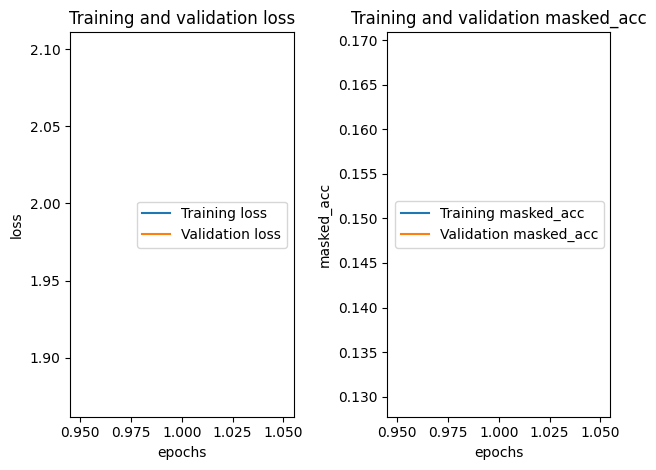

In [32]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 1 # 20 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
MASK_ZERO = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    dropout=0.35,
    latent_dim=512,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    vocab_size=VOCABULARY_SIZE,
    batch_size=8,
    embedding_dim=128,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

# optimizer = keras.optimizers.AdamW(
#     learning_rate=LEARNING_RATE,
# )
# best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_masked_acc"]))
# best_epoch = best_epoch + 1
# print("best_epoch is", best_epoch)
# model, filepath, history = build_model(
#     train_ds.concatenate(validation_ds), None, test_ds,
#     vectorization_layer=vectorization_layer,
#     dropout=0.35,
#     latent_dim=512,
#     encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
#     decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
#     vocab_size=VOCABULARY_SIZE,
#     batch_size=128,
#     embedding_dim=128,
#     mask_zero=MASK_ZERO,
#     optimizer=optimizer,
#     epochs=best_epoch,
#     steps_per_epoch=STEPS_PER_EPOCH,
#     callbacks=[reduce_lr_callbacks],
# )

# y_true, y_pred = predict_dataset(
#     model=model,
#     iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
#     decoder_sequence_length=DECODER_SEQUENCE_LENGTH
# )
# rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
#     y_true=y_true,
#     y_pred=y_pred
# )
# print(rouge_1_score)
# print(rouge_2_score)
# print(rouge_l_score)

In [21]:
#y_true[:5]

In [22]:
#y_pred[:5]

In [23]:
decoder_tokenizer = model.decoder_tokenizer
vocab = decoder_tokenizer.get_vocabulary()
index_lookup_table = dict(zip(range(len(vocab)), vocab))

In [24]:
decode_sequence(
    input_sentence="Edward: Rachel, I think I'm in ove with Bella.. rachel: Dont say anything else.. Edward: What do you mean?? rachel: Open your fu**ing door.. I'm outside",
    model=model,
    lookup_table=index_lookup_table,
    max_sequence_length=64,
)

'[start] tom is going to buy a new android phone [end]'

In [35]:
def decode_sequence_functionally(
        input_sentence,
        model,
        input_vectorization_layer,
        target_vectorization_layer,
        max_sequence_length,
        lookup_table):
    """
    Generate summarized text from the input sentence.
    :input_sentence: the original text that is summarized
    :model: the Seq2SeqModel class model
    :max_sequence_length: the maximum length of the summarized text
    :lookup_table: the table holds token IDs and their actual words
    """
    encoder_tokenizer = input_vectorization_layer
    decoder_tokenizer = target_vectorization_layer
    tokenized_input = encoder_tokenizer([input_sentence])

    start_token = decoder_tokenizer("[start]")[0].numpy()
    end_token = decoder_tokenizer("[end]")[0].numpy()

    decoded_sentence = [start_token]
    for i in range(max_sequence_length):
        decoder_inputs = tf.convert_to_tensor(
            [decoded_sentence],
            dtype="int64",
        )
        decoder_inputs = tf.concat(
            [
                decoder_inputs,
                tf.zeros(
                    [1, max_sequence_length - i - 1],
                    dtype="int64",
                ),
            ],
            axis=1,
        )
        input = (
            tokenized_input,
            decoder_inputs,
        )
        predictions = model(input)
        predicted_token = np.argmax(predictions[0, i, :])
        decoded_sentence.append(predicted_token)
        if predicted_token == end_token:
            break

    detokenized_output = []
    for token in decoded_sentence:
        detokenized_output.append(lookup_table[token])
    return " ".join(detokenized_output)

input_vectorization_layer, target_vectorization_layer = prepare_tokenizer(
    vectorization_layer=vectorization_layer,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    max_tokens=vectorization_layer.vocabulary_size(),
)

decode_sequence_functionally(
    input_sentence="Edward: Rachel, I think I'm in ove with Bella.. rachel: Dont say anything else.. Edward: What do you mean?? rachel: Open your fu**ing door.. I'm outside",
    model=model,
    input_vectorization_layer=input_vectorization_layer,
    target_vectorization_layer=target_vectorization_layer,
    lookup_table=index_lookup_table,
    max_sequence_length=64,
)

'[start] tom and tom are going to meet at the cinema [end]'